In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch

import metatensor.torch as mts
from metatensor.torch import TensorMap, TensorBlock, Labels

from metatrain.utils.data import read_systems
from metatrain.utils.architectures import get_default_hypers

from metatrain.experimental.nanopet import elearn
from metatrain.experimental.nanopet.pet_basis import NanoPetOnBasis

from featomic.torch import SphericalExpansion, SphericalExpansionByPair
from featomic.torch.clebsch_gordan import EquivariantPowerSpectrum, EquivariantPowerSpectrumByPair

torch.set_default_dtype(torch.float64)

In [4]:
### ===== Generate target data - in this an EquivariantPowerSpectrum ===== ### 

# SphEx hypers
hypers = {
    'cutoff': {'radius': 3.5,
    'smoothing': {'type': 'ShiftedCosine', 'width': 0.1}},
    'density': {'type': 'Gaussian', 'width': 0.3},
    'basis': {'type': 'TensorProduct',
    'max_angular': 5,
    'radial': {'type': 'Gto', 'max_radial': 2}}
}

# Load frames
n_frames = 100
systems = read_systems("/Users/joe.abbott/Desktop/tmp_cubes/qm7x_reduced_100.xyz")
systems = [s.to(torch.float64) for s in systems][:n_frames]

# Calculators
eps_calc_1c = EquivariantPowerSpectrum(SphericalExpansion(**hypers))
eps_calc_2c = EquivariantPowerSpectrumByPair(
    SphericalExpansion(**hypers),
    SphericalExpansionByPair(**hypers)
  )

# Compute EqPowSpecs
Lmax = 5
selected_keys = mts.Labels(
    ["o3_lambda"],
    torch.tensor([[o3_lambda] for o3_lambda in range(Lmax + 1)]).reshape(-1, 1)
)
target_node = eps_calc_1c.compute(
    systems,
    selected_keys=selected_keys,
    neighbors_to_properties=False,
)
target_edge = eps_calc_2c.compute(
    systems,
    selected_keys=selected_keys,
    neighbors_to_properties=False,
)

# Sum over neighbor types
target_node = target_node.keys_to_samples(["neighbor_1_type", "neighbor_2_type"])
target_node = mts.sum_over_samples(target_node, ["neighbor_1_type", "neighbor_2_type"])
# target_edge = target_edge.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])

# Sum over neighbor types, permute dimensions, split nodes and edges
target_edge = target_edge.keys_to_samples(["neighbor_1_type"])
target_edge = elearn.drop_empty_blocks(target_edge)
target_edge = mts.sum_over_samples(target_edge, ["neighbor_1_type"])
target_edge = mts.permute_dimensions(target_edge, "properties", [2, 0, 3, 1])
target_edge = elearn.get_edges(target_edge)

# Save
mts.save("target_node.npz", target_node)
mts.save("target_edge.npz", target_edge)

In [13]:
# Load the total data
target_node = mts.load("target_node.npz")
target_edge = mts.load("target_edge.npz")

# Select a subset of the target blocks - node
# key_selection_node = target_node.keys.select(
#     mts.Labels(
#         ["o3_lambda", "o3_sigma", "center_type"],
#         torch.tensor(
#             [
#                 # [0, 1, 6],
#                 [1, 1, 6],
#                 # [2, 1, 6],
#                 # [0, 1, 1],
#                 # [1, 1, 1],
#                 # [2, 1, 1],
#             ]
#         )
#     )
# )
# selected_keys_node = mts.Labels(
#         target_node.keys.names,
#         target_node.keys.values[key_selection_node],
#     )
# target_node = mts.TensorMap(
#     selected_keys_node,
#     [target_node[key] for key in selected_keys_node],
# )

# Triangularize in center type
key_selection_edge = target_edge.keys.select(
    mts.Labels(
        ["o3_lambda", "o3_sigma", "first_atom_type", "second_atom_type"],
        torch.tensor(
            target_edge.keys.values[
                target_edge.keys.values[:, 2] <= target_edge.keys.values[:, 3]
            ]
        )
    )
)
# Select a subset of the target blocks - edge
# key_selection_edge = target_edge.keys.select(
#     mts.Labels(
#         ["o3_lambda", "o3_sigma", "first_atom_type", "second_atom_type"],
#         torch.tensor(
#             [
#                 # [0, 1, 6, 6],
#                 # [1, 1, 6, 6],
#                 # [2, 1, 6, 6],
#                 # [0, 1, 1, 6],
#                 [1, 1, 1, 6],
#                 # [2, 1, 1, 6],
#                 # [8, 1, 1, 6],
#             ]
#         )
#     )
# )
selected_keys_edge = mts.Labels(
        target_edge.keys.names,
        target_edge.keys.values[key_selection_edge],
    )
target_edge = mts.TensorMap(
    selected_keys_edge,
    [target_edge[key] for key in selected_keys_edge],
)

# Get the metadata for initializing PET
metadata = {
    "in_keys_node": target_node.keys,
    "in_keys_edge": target_edge.keys,
    "out_properties_node": [block.properties for block in target_node],
    "out_properties_edge": [block.properties for block in target_edge],
}

/var/folders/rj/yfjmvs6s2bx3r6v3hs3fc9600000gn/T/ipykernel_29605/2469133368.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(


In [14]:
# Train val split
n_train, n_val = 80, 20
all_id = np.arange(n_frames)
rng = np.random.default_rng()
rng.shuffle(all_id)
train_id = all_id[:n_train].tolist()
val_id = all_id[n_train:n_train + n_val].tolist()

# Datasets
train_dataset = elearn.get_dataset(systems, train_id, target_node, target_edge)
val_dataset = elearn.get_dataset(systems, val_id, target_node, target_edge)

# Dataloaders
train_dloader = elearn.get_dataloader(train_dataset, batch_size=10)
val_dloader = elearn.get_dataloader(val_dataset, batch_size=10)

# Target standardizers
all_target_node = mts.join(
    [train_dataset.get_sample(A).targets_node for A in train_id],
    "samples",
    remove_tensor_name=True,
    different_keys="union",
)
all_target_edge = mts.join(
    [train_dataset.get_sample(A).targets_edge for A in train_id],
    "samples",
    remove_tensor_name=True,
    different_keys="union",
)
standardizers = {
    "node_mean": elearn.get_tensor_invariant_mean(all_target_node),
    "node_std": elearn.get_tensor_std(all_target_node),
    "edge_mean": elearn.get_tensor_invariant_mean(all_target_edge),
    "edge_std": elearn.get_tensor_std(all_target_edge),
}

# Rotational augmenter
rotational_augmenter = elearn.get_augmenter(target_node, target_edge)

In [15]:
# Initialize model
pet_hypers = get_default_hypers("experimental.nanopet")["model"]
pet_hypers["cutoff"] = hypers["cutoff"]["radius"]
pet_hypers["cutoff_width"] = 0.1
pet_hypers["d_pet"] = 64
atomic_types = [1, 6, 7, 16]

# Node and edge model
model = NanoPetOnBasis(
    atomic_types=atomic_types,
    **metadata,
    pet_hypers=pet_hypers,
    head_hidden_layer_widths=[64, 64, 64],
    standardizers=standardizers,
)

# Optimizer, scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

train_losses = []
val_losses = []

In [16]:
# Train
epochs = 501
for epoch in range(epochs):

    # Training batches
    model.train()
    epoch_loss_train = 0
    for train_batch in train_dloader:
        optimizer.zero_grad()  # zero gradients

        # Get the systems and targets for the batch - node and edge
        systems_train, targets_train_node, targets_train_edge = train_batch.systems, train_batch.targets_node, train_batch.targets_edge

        # # Define a random transformation for each training system
        # rotations, inversions = elearn.get_system_transformations(systems_train)

        # # Apply rotational augmentation - node
        # if model.in_keys_node is not None:
        #     systems_train, targets_train_node = rotational_augmenter.apply_augmentations(
        #         systems_train, {"mtt::target_node": targets_train_node}, rotations, inversions
        #     )
        #     targets_train_node = targets_train_node["mtt::target_node"]
        #     assert mts.equal_metadata(train_batch.targets_node, targets_train_node)
        #     assert not mts.allclose(train_batch.targets_node, targets_train_node)

        # # Apply rotational augmentation - edge
        # if model.in_keys_edge is not None:
        #     systems_train, targets_train_edge = rotational_augmenter.apply_augmentations(
        #         systems_train, {"mtt::target_edge": targets_train_edge}, rotations, inversions
        #     )
        #     targets_train_edge = targets_train_edge["mtt::target_edge"]
        #     assert mts.equal_metadata(train_batch.targets_edge, targets_train_edge)
        #     assert not mts.allclose(train_batch.targets_edge, targets_train_edge)
        
        # Get predictions and check metadata
        predictions_train_node, predictions_train_edge = model(systems_train, train_batch.sample_id)

        # Evaluate loss
        train_loss = 0
        if model.in_keys_node is not None:
            train_loss += elearn.l2loss(predictions_train_node, targets_train_node)
        if model.in_keys_edge is not None:
            train_loss += elearn.l2loss(predictions_train_edge, mts.sort(targets_train_edge, "samples"))

        # Update weights
        train_loss.backward()
        optimizer.step()
        epoch_loss_train += train_loss.item()


    # Validation batches
    with torch.no_grad():
        model.eval()
        epoch_loss_val = 0
        for val_batch in val_dloader:
            optimizer.zero_grad()  # zero gradients

            # Get the systems and targets for the batch - node and edge
            systems_val, targets_val_node, targets_val_edge = val_batch.systems, val_batch.targets_node, val_batch.targets_edge
            
            # Get predictions and check metadata
            predictions_val_node, predictions_val_edge = model(systems_val, val_batch.sample_id)

            # Evaluate loss
            val_loss = 0
            if model.in_keys_node is not None:
                val_loss += elearn.l2loss(predictions_val_node, targets_val_node)
            if model.in_keys_edge is not None:
                val_loss += elearn.l2loss(predictions_val_edge, mts.sort(targets_val_edge, "samples"))
            epoch_loss_val += val_loss.item()

    train_losses.append(epoch_loss_train / len(train_id))
    val_losses.append(epoch_loss_val / len(val_id))

    # scheduler.step(epoch_loss_val)
    if epoch % 1 == 0:
        print(f"Epoch {epoch} train_loss: {epoch_loss_train} val_loss: {epoch_loss_val} LR: {optimizer.param_groups[0]['lr']}")

Epoch 0 train_loss: 3050747.8847363726 val_loss: 346429.50653449923 LR: 0.01
Epoch 1 train_loss: 551139.0886102791 val_loss: 38070.21460721244 LR: 0.01
Epoch 2 train_loss: 102276.16705109843 val_loss: 15777.038277625332 LR: 0.01
Epoch 3 train_loss: 47750.826192149114 val_loss: 8139.931840420459 LR: 0.01
Epoch 4 train_loss: 39825.37534388185 val_loss: 44536.82807732383 LR: 0.01
Epoch 5 train_loss: 527619.5387094957 val_loss: 36503.836754580174 LR: 0.01
Epoch 6 train_loss: 90234.89591273031 val_loss: 13962.888279918734 LR: 0.01
Epoch 7 train_loss: 38553.22860341776 val_loss: 6851.871864874718 LR: 0.01
Epoch 8 train_loss: 22330.86840445472 val_loss: 4536.913534076581 LR: 0.01
Epoch 9 train_loss: 15689.415936308887 val_loss: 3328.703679319413 LR: 0.01
Epoch 10 train_loss: 12171.017963461854 val_loss: 2814.353774435587 LR: 0.01
Epoch 11 train_loss: 10446.931116434092 val_loss: 2505.8676684704487 LR: 0.01
Epoch 12 train_loss: 9380.872845670436 val_loss: 2293.8558193950025 LR: 0.01
Epoch 13 t

KeyboardInterrupt: 

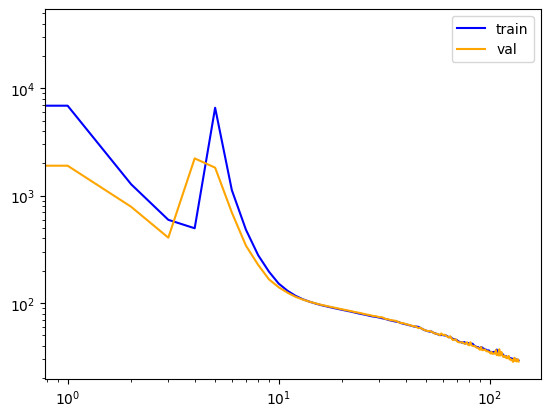

In [17]:
# Training curve
fig, ax = plt.subplots()
ax.plot(np.arange(len(train_losses)), train_losses, label="train", c="blue")
ax.plot(np.arange(len(val_losses)), val_losses, label="val", c="orange")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

In [24]:
# Equivariance evaluation
model.eval()

import numpy as np
from scipy.spatial.transform import Rotation

systems_train = [train_dataset.get_sample(A).systems for A in train_id]
systems_val = [val_dataset.get_sample(A).systems for A in val_id]

# Get targets
if model.in_keys_node is not None:
    train_targets_node = mts.join(
        [
            train_dataset.get_sample(A).targets_node for A in train_id
        ],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )
    val_targets_node = mts.join(
        [
            val_dataset.get_sample(A).targets_node for A in val_id
        ],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )

if model.in_keys_edge is not None:
    train_targets_edge = mts.join(
        [
            train_dataset.get_sample(A).targets_edge for A in train_id
        ],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )
    val_targets_edge = mts.join(
        [
            val_dataset.get_sample(A).targets_edge for A in val_id
        ],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )

In [18]:
# Make evaluation predictions
model.eval()

# Get predictions
train_predictions_node, train_predictions_edge = model(
    [train_dataset.get_sample(A).systems for A in train_id],
    train_id,
)
val_predictions_node, val_predictions_edge = model(
    [val_dataset.get_sample(A).systems for A in val_id],
    val_id,
)

# Get targets
if model.in_keys_node is not None:
    train_targets_node = mts.join(
        [
            train_dataset.get_sample(A).targets_node for A in train_id
        ],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )
    val_targets_node = mts.join(
        [
            val_dataset.get_sample(A).targets_node for A in val_id
        ],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )
    mts.equal_metadata_raise(train_targets_node, train_predictions_node)
    mts.equal_metadata_raise(val_targets_node, val_predictions_node)

if model.in_keys_edge is not None:
    train_targets_edge = mts.join(
        [
            train_dataset.get_sample(A).targets_edge for A in train_id
        ],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )
    val_targets_edge = mts.join(
        [
            val_dataset.get_sample(A).targets_edge for A in val_id
        ],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )
    mts.equal_metadata_raise(mts.sort(train_targets_edge, "samples"), train_predictions_edge)
    mts.equal_metadata_raise(mts.sort(val_targets_edge, "samples"), val_predictions_edge)

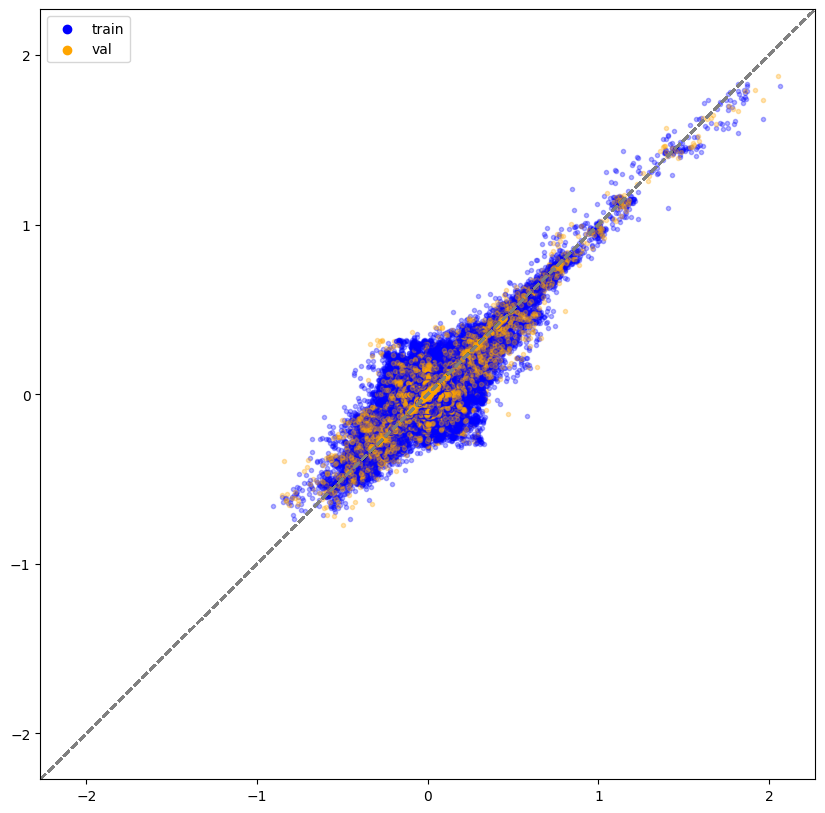

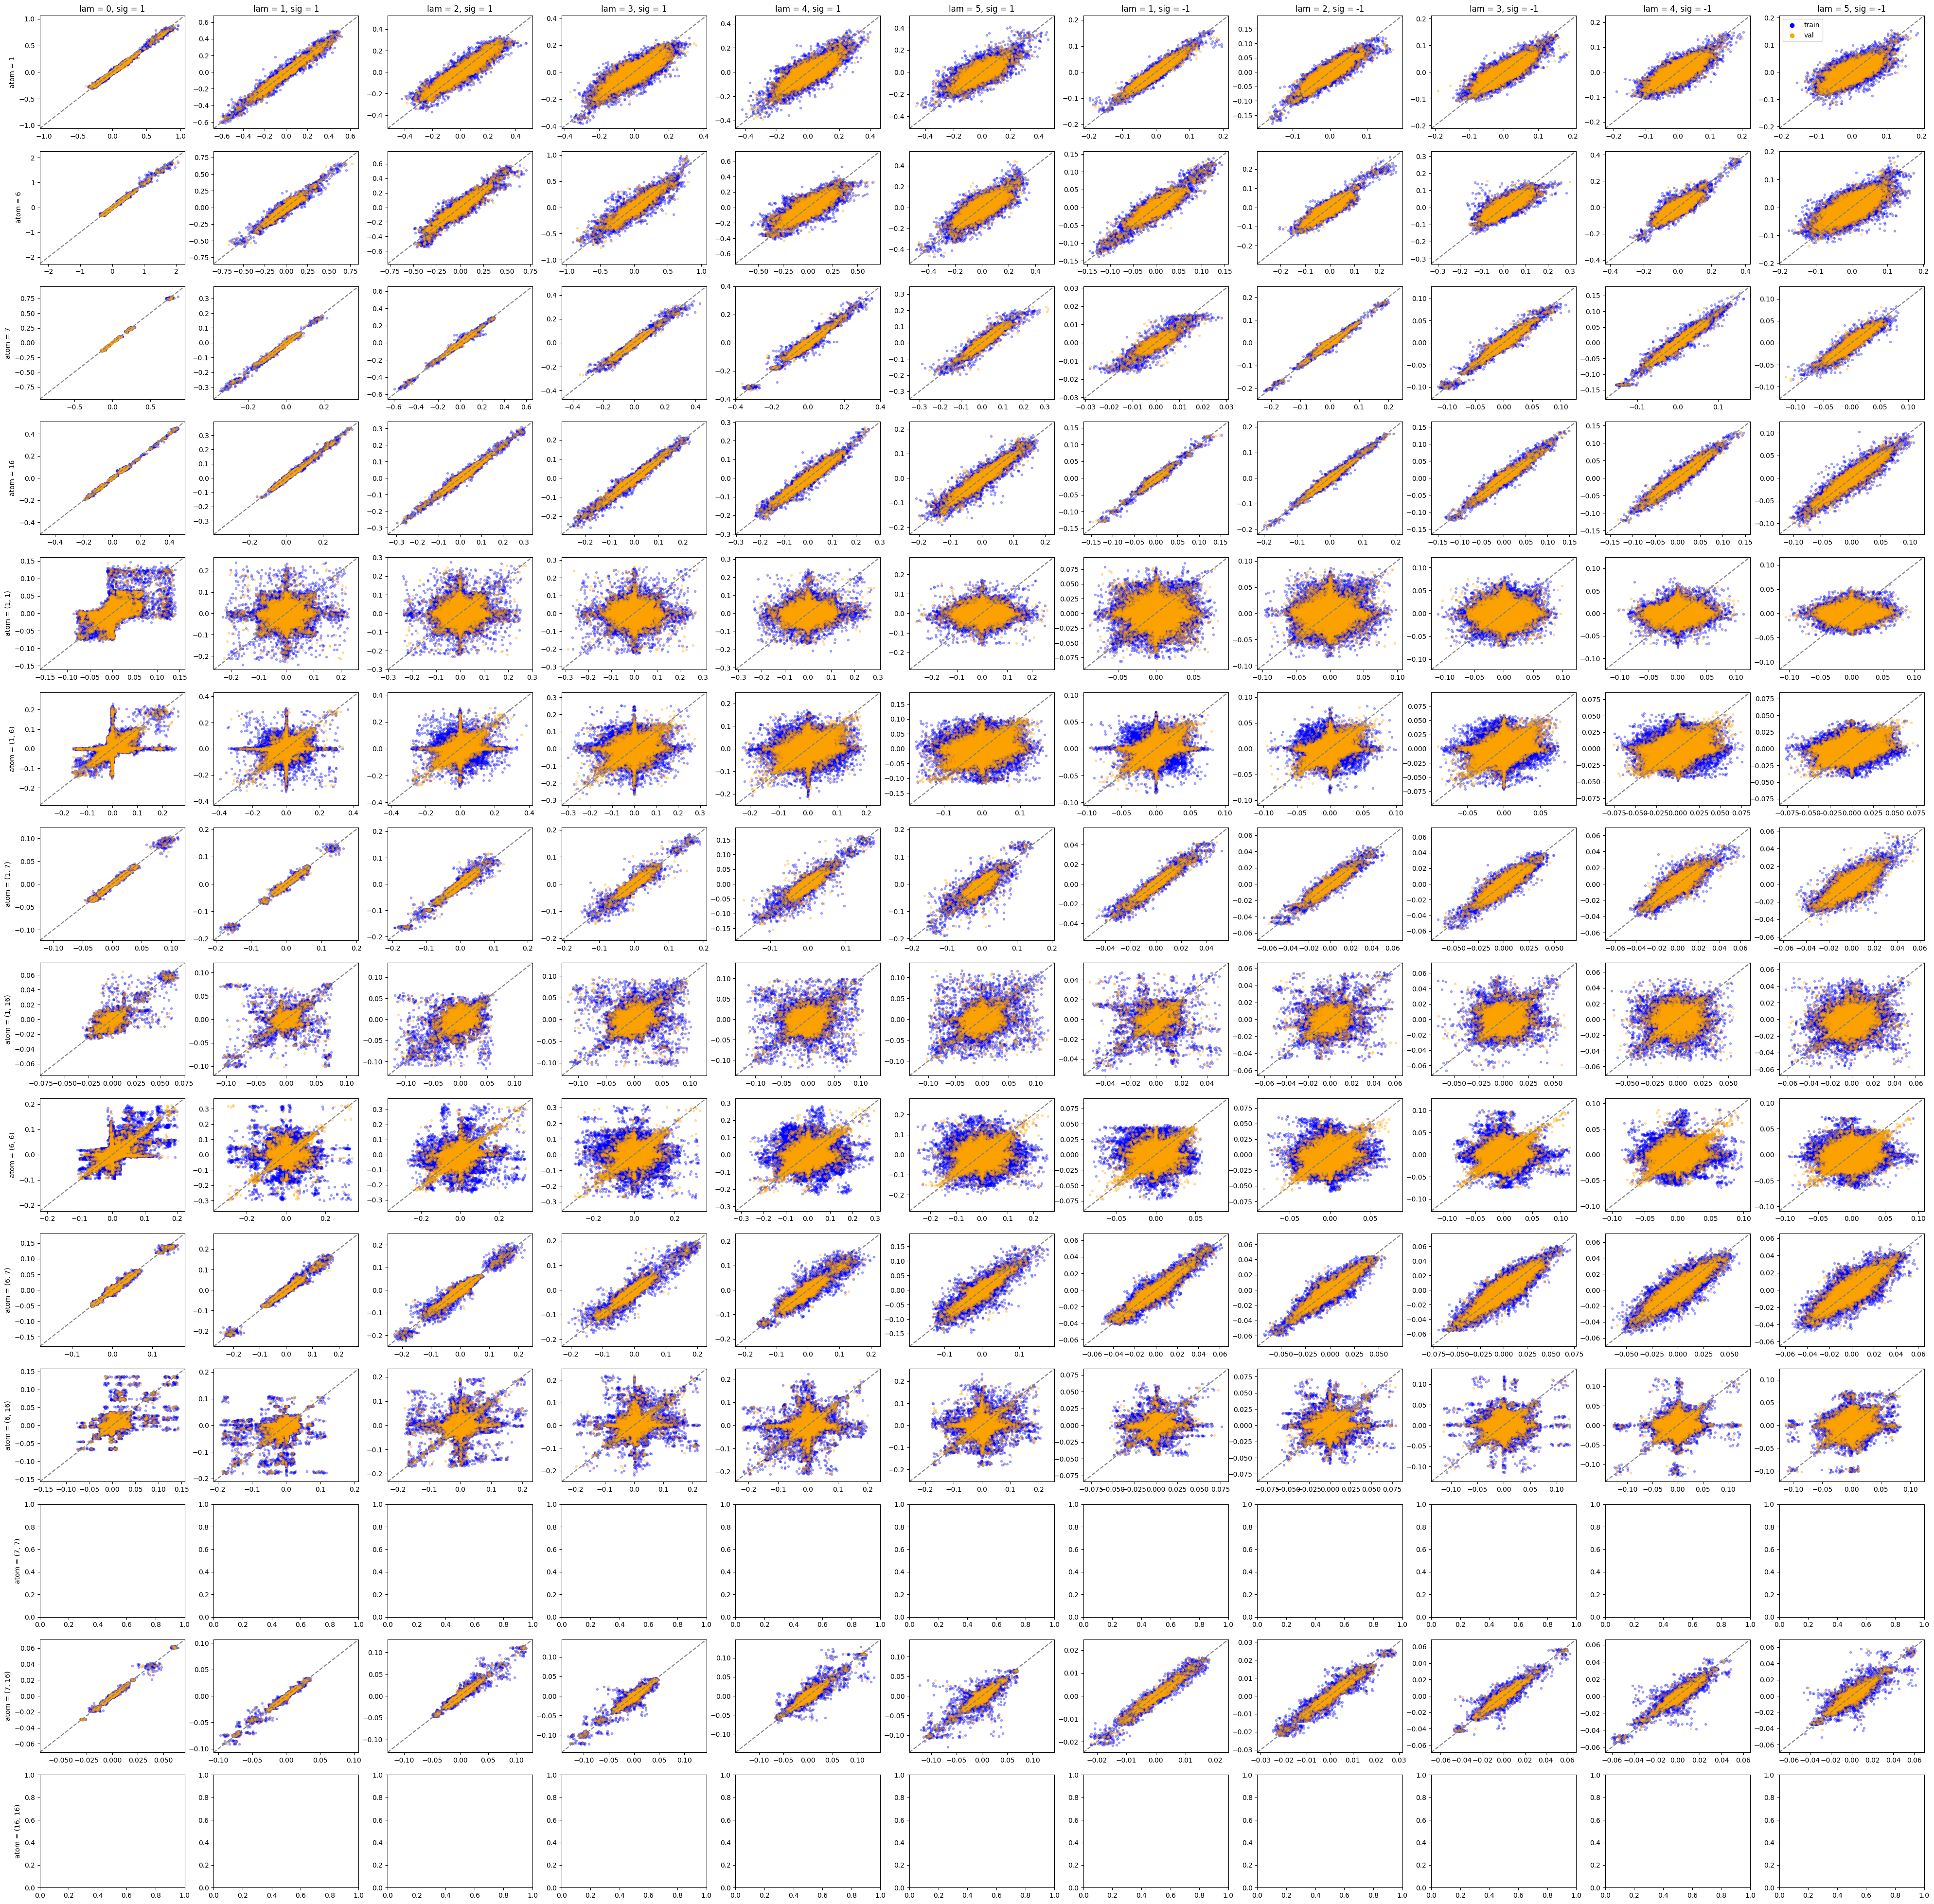

In [19]:
# Setup plots
row_idxs = {}
flat_idx = 0
for alpha in atomic_types:
    row_idxs[alpha] = flat_idx
    flat_idx += 1

for alpha_1 in atomic_types:
    for alpha_2 in atomic_types:
        if alpha_1 <= alpha_2:
            row_idxs[(alpha_1, alpha_2)] = flat_idx
            flat_idx += 1

fig_1, ax_1 = plt.subplots(figsize=(10, 10))
fig_2, axes_2 = plt.subplots(len(row_idxs), (Lmax + 1) * 2 - 1, figsize=(50, 50))

# Plot nodes
ax_1_lim = 0
if model.in_keys_node is not None:
    for key in train_targets_node.keys:

        ax_2 = axes_2[
            row_idxs[key["center_type"]],
            key["o3_lambda"] + (0 if key["o3_sigma"] == 1 else Lmax),
        ]
        
        train_x = train_targets_node[key].values.flatten().detach().numpy()
        train_y = train_predictions_node[key].values.flatten().detach().numpy()
        val_x = val_targets_node[key].values.flatten().detach().numpy()
        val_y = val_predictions_node[key].values.flatten().detach().numpy()
        ax_lim = np.max(
            np.abs(np.concatenate([train_x, val_x, train_y, val_y]))
        ) * 1.1
        ax_1_lim = max(ax_1_lim, ax_lim)
        ax_2.set_xlim([-ax_lim, ax_lim])
        ax_2.set_ylim([-ax_lim, ax_lim])
        for ax in [ax_1, ax_2]:
            ax.scatter(train_x, train_y, alpha=0.3, marker=".", c="blue")
            ax.scatter(val_x, val_y, alpha=0.3, marker=".", c="orange")
            ax.axline([0, 0], slope=1, linestyle="--", c="gray")

# Plot edges
if model.in_keys_edge is not None:
    for key in train_targets_edge.keys:

        ax_2 = axes_2[
            row_idxs[(key["first_atom_type"], key["second_atom_type"])],
            key["o3_lambda"] + (0 if key["o3_sigma"] == 1 else Lmax),
        ]
        
        train_x = train_targets_edge[key].values.flatten().detach().numpy()
        train_y = train_predictions_edge[key].values.flatten().detach().numpy()
        val_x = val_targets_edge[key].values.flatten().detach().numpy()
        val_y = val_predictions_edge[key].values.flatten().detach().numpy()
        ax_lim = np.max(
            np.abs(np.concatenate([train_x, val_x, train_y, val_y]))
        ) * 1.1
        ax_1_lim = max(ax_1_lim, ax_lim)
        ax_2.set_xlim([-ax_lim, ax_lim])
        ax_2.set_ylim([-ax_lim, ax_lim])
        for ax in [ax_1, ax_2]:
            ax.scatter(train_x, train_y, alpha=0.3, marker=".", c="blue")
            ax.scatter(val_x, val_y, alpha=0.3, marker=".", c="orange")
            ax.axline([0, 0], slope=1, linestyle="--", c="gray")

# Format ax_1
ax_1.set_xlim([-ax_1_lim, ax_1_lim])
ax_1.set_ylim([-ax_1_lim, ax_1_lim])
ax_1.scatter([None], [None], label="train", c="blue")
ax_1.scatter([None], [None], label="val", c="orange")
ax_1.legend()

# Format axes_2
axes_2[0, -1].scatter([None], [None], label="train", c="blue")
axes_2[0, -1].scatter([None], [None], label="val", c="orange")
axes_2[0, -1].legend()
for key, idx in row_idxs.items():
    axes_2[idx, 0].set_ylabel(f"atom = {key}")
[
    ax.set_title(f"lam = {lam}, sig = {sig}") 
    for lam, sig, ax in zip(list(range(Lmax + 1)) + list(range(1, Lmax + 1)), ([1] * (Lmax + 1)) + ([-1] * (Lmax + 1)), axes_2[0, :])
];

In [53]:
# Augment systems and targets with rotations around Z
losses = {"train_node": [], "train_edge": [], "val_node": [], "val_edge": []}
Z = np.linspace(0, 2 * np.pi, 7)
for z in Z:
    
    # Define transformations
    rotations = [
        Rotation.from_euler("ZYZ", [0, 0, z])
        for _ in systems_train
    ]
    inversions = [1 for _ in systems_train]
    
    # TRAIN: Apply rotational augmentation - node
    if model.in_keys_node is not None:
        systems_train_, train_targets_node_ = rotational_augmenter.apply_augmentations(
            systems_train,
            {"mtt::target_node": train_targets_node},
            rotations,
            inversions,
        )
        train_targets_node_ = train_targets_node_["mtt::target_node"]

    # TRAIN: Apply rotational augmentation - edge
    if model.in_keys_edge is not None:
        systems_train_, train_targets_edge_ = rotational_augmenter.apply_augmentations(
            systems_train,
            {"mtt::target_edge": train_targets_edge},
            rotations,
            inversions,
        )
        train_targets_edge_ = train_targets_edge_["mtt::target_edge"]
        
    # TRAIN: Get predictions
    train_predictions_node_, train_predictions_edge_ = model(
        systems_train_,
        train_id,
    )
    assert mts.equal_metadata(train_targets_node, train_targets_node_)
    assert not mts.allclose(train_targets_node, train_targets_node_)
    assert mts.equal_metadata(train_targets_edge, train_targets_edge_)
    assert not mts.allclose(train_targets_edge, train_targets_edge_)

    # VAL: Apply rotational augmentation - node
    if model.in_keys_node is not None:
        systems_val_, val_targets_node_ = rotational_augmenter.apply_augmentations(
            systems_val,
            {"mtt::target_node": val_targets_node},
            rotations,
            inversions,
        )
        val_targets_node_ = val_targets_node_["mtt::target_node"]

    # VAL: Apply rotational augmentation - edge
    if model.in_keys_edge is not None:
        systems_val_, val_targets_edge_ = rotational_augmenter.apply_augmentations(
            systems_val,
            {"mtt::target_edge": val_targets_edge},
            rotations,
            inversions,
        )
        val_targets_edge_ = val_targets_edge_["mtt::target_edge"]
        
    # VAL: Get predictions
    val_predictions_node_, val_predictions_edge_ = model(
        systems_val_,
        val_id,
    )
    assert mts.equal_metadata(val_targets_node, val_targets_node_)
    assert not mts.allclose(val_targets_node, val_targets_node_)
    assert mts.equal_metadata(val_targets_edge, val_targets_edge_)
    assert not mts.allclose(val_targets_edge, val_targets_edge_)

    # Compute losses and store
    losses["train_node"].append(
        elearn.l2loss(train_targets_node, train_targets_node_) / len(systems_train_)
    )
    losses["train_edge"].append(
        elearn.l2loss(train_targets_edge, train_targets_edge_) / len(systems_train_)
    )
    losses["val_node"].append(
        elearn.l2loss(val_targets_node, val_targets_node_) / len(systems_val_)
    )
    losses["val_edge"].append(
        elearn.l2loss(val_targets_edge, val_targets_edge_) / len(systems_val_)
    )

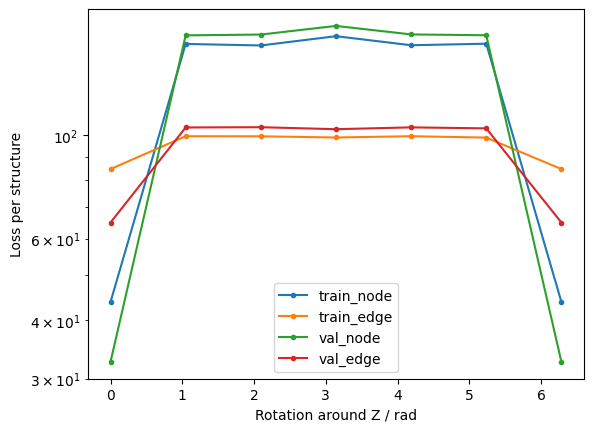

In [55]:
# Plot loss as a function of Z rotation
fig, ax = plt.subplots()
for line in losses.keys():
    ax.plot(Z, losses[line], label=line, marker=".")
    # ax.plot(list(Z[:6]) + list(Z[:6][::-1]), losses[line], label=line, marker=".")
ax.legend()
ax.set_xlabel("Rotation around Z / rad")
ax.set_ylabel("Loss per structure")
ax.set_yscale("log")